### Analyse tip behaviour

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium 

In [2]:
from pyspark.sql import SparkSession

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

22/08/21 11:43:47 WARN Utils: Your hostname, mast30034 resolves to a loopback address: 127.0.1.1; using 45.113.234.45 instead (on interface eth0)
22/08/21 11:43:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 11:43:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/21 11:43:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/21 11:43:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/21 11:43:48 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


### Visualise average tips per month

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *

month = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
average_tips_per_month = []

files = ['final-2018-10.parquet', 'final-2018-11.parquet', 'final-2018-12.parquet', 'final-2019-01.parquet', 
         'final-2019-02.parquet', 'final-2019-03.parquet']

for file in files:
    taxi_weather_month = spark.read.parquet(f'../data/curated/taxi_weather_data/{file}')
    average_tips = taxi_weather_month.select(mean(col('tip_amount')).alias('avg_tips')).collect()
    
    # get average tips for each month
    avg_monthly_tip = average_tips[0]['avg_tips']
    average_tips_per_month.append(avg_monthly_tip)

    
print(average_tips_per_month)


[2.7171423926884057, 2.706787751214093, 2.680333181004238, 2.517044735154959, 2.8956499015190045, 2.991195600874555]


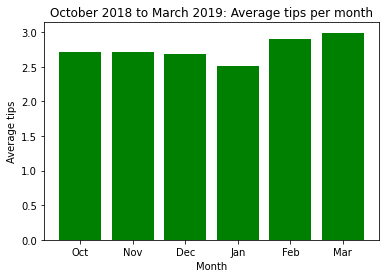

In [4]:
# bar plot of average tips per month from Oct-2018 to Mar-2019

x_pos = np.arange(len(month))
plt.bar(month, average_tips_per_month, color='green')
plt.title('October 2018 to March 2019: Average tips per month')
plt.xlabel('Month')
plt.ylabel('Average tips')
plt.xticks(x_pos, month)
plt.savefig('../plots/average_tips_per_month.png')
plt.show()

### Visualise average tips by day of week

In [5]:
from statistics import mean

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_tips_monday = []
avg_tips_tuesday = []
avg_tips_wednesday = []
avg_tips_thursday = []
avg_tips_friday = []
avg_tips_saturday = []
avg_tips_sunday = []

files = ['final-2018-10.parquet', 'final-2018-11.parquet', 'final-2018-12.parquet', 'final-2019-01.parquet', 
         'final-2019-02.parquet', 'final-2019-03.parquet']

for file in files:
    taxi_weather_month = spark.read.parquet(f'../data/curated/taxi_weather_data/{file}')
    # get avg tips per day of week for every month + order days of week alphabetically
    avg_tips_per_day = taxi_weather_month.groupBy('pickup_day').mean('tip_amount').orderBy('pickup_day').collect()
    
    avg_tips_monday.append(avg_tips_per_day[1]['avg(tip_amount)'])
    avg_tips_tuesday.append(avg_tips_per_day[5]['avg(tip_amount)'])
    avg_tips_wednesday.append(avg_tips_per_day[6]['avg(tip_amount)'])
    avg_tips_thursday.append(avg_tips_per_day[4]['avg(tip_amount)'])
    avg_tips_friday.append(avg_tips_per_day[0]['avg(tip_amount)'])
    avg_tips_saturday.append(avg_tips_per_day[2]['avg(tip_amount)'])
    avg_tips_sunday.append(avg_tips_per_day[3]['avg(tip_amount)'])


# get averages of monthly tip amount per day of the week
average_tips_per_day = [mean(avg_tips_monday), mean(avg_tips_tuesday), mean(avg_tips_wednesday), 
                        mean(avg_tips_thursday), mean(avg_tips_friday), mean(avg_tips_saturday), mean(avg_tips_sunday)]


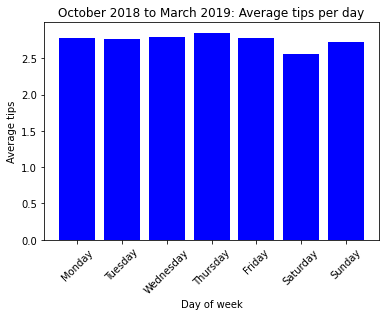

In [6]:
# bar plot of average tips per day of week from Oct-2018 to Mar-2019

x_pos = np.arange(len(days))
plt.bar(days, average_tips_per_day, color='blue')
plt.title('October 2018 to March 2019: Average tips per day')
plt.xlabel('Day of week')
plt.ylabel('Average tips')
plt.xticks(x_pos, days, rotation = 45)
plt.savefig('../plots/average_tips_per_day.png')
plt.show()

### Analyse which pick up areas have highest average tips for December 2018

In [7]:
## The following was modified from MAST30034 Tutorial 2
# read in shape file
sf = gpd.read_file("../data/raw/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/raw/taxi_zones/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
## attributed: https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/understand-epsg-wkt-and-other-crs-definition-file-types/ 
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# join taxi zones with shape file
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()


In [8]:
# add airports information
gdf['centroid'] = gdf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
gdf[['Zone', 'LocationID', 'centroid']].head()


,Zone,LocationID,centroid
0,Newark Airport,1,"(40.69183120640149, -74.17400027276298)"
1,Jamaica Bay,2,"(40.61674529165988, -73.83129854302214)"
2,Allerton/Pelham Gardens,3,"(40.86447368477543, -73.84742223236718)"
3,Alphabet City,4,"(40.72375214158478, -73.97696825691767)"
4,Arden Heights,5,"(40.552659286945655, -74.18848410184931)"


In [9]:
# get taxi_weather data for Dec 2018
taxi_weather_dec = pd.read_parquet('../data/curated/taxi_weather_data/final-2018-12.parquet')

# join shape file to taxi weather data for Dec 2018 by pick up location
pu_df = taxi_weather_dec \
    .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

pu_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,pickup_date,pickup_hour,pickup_day,DATE,average_temp,average_dew_point,average_wind_speed,geometry
0,2018-12-01 00:28:22,2018-12-01 00:44:07,2.0,2.50,1.0,148,234,1,3.95,17.25,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98448 40.72023, -73.98507 40.719..."
1,2018-12-01 00:42:46,2018-12-01 00:55:13,1.0,3.90,1.0,148,140,1,2.85,17.15,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98448 40.72023, -73.98507 40.719..."
2,2018-12-01 00:03:46,2018-12-01 00:15:47,2.0,1.70,1.0,148,90,1,2.15,12.95,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98448 40.72023, -73.98507 40.719..."
3,2018-12-01 00:20:45,2018-12-01 00:35:23,1.0,1.47,1.0,148,125,1,0.50,12.30,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98448 40.72023, -73.98507 40.719..."
4,2018-12-01 00:36:42,2018-12-01 00:41:45,1.0,0.70,1.0,148,144,1,0.94,7.24,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98448 40.72023, -73.98507 40.719..."


In [10]:
# calculate average tips by drop off location
pu_tip_amount = pu_df[['PULocationID', 'tip_amount']] \
                .groupby('PULocationID') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'PULocationID': 'count' # count number of instances from sample
                    }
                ) \
                .rename({'PULocationID': 'total_trips'}, axis=1)

pu_tip_amount['average_tip_amount'] = pu_tip_amount['tip_amount'] / pu_tip_amount['total_trips']
pu_tip_amount.head()


,tip_amount,total_trips,average_tip_amount
PULocationID,,,
1,1976.28,152,13.001842
2,51.92,7,7.417143
3,128.08,142,0.901972
4,24849.76,10746,2.312466
5,29.08,11,2.643636


In [11]:
pu_map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# add average tips
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=pu_df, # data source
    columns=['PULocationID','tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tips USD$'
)
c.add_to(pu_map)

# add airport markers
for zone_name, coord in gdf.loc[gdf['Zone'].str.contains('Airport'), ['Zone', 'centroid']].values:
    pu_map.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )

pu_map.save('../plots/ChloroplethMap_pickup_average_tips.html')

#### Analyse which drop off areas have highest average tips for Dec 2018

In [12]:
# join shape file to taxi weather data for Dec 2018 by drop off location
do_df = taxi_weather_dec \
    .merge(gdf[['LocationID', 'geometry']], left_on='DOLocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

do_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,pickup_date,pickup_hour,pickup_day,DATE,average_temp,average_dew_point,average_wind_speed,geometry
0,2018-12-01 00:28:22,2018-12-01 00:44:07,2.0,2.50,1.0,148,234,1,3.95,17.25,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98997 40.73490, -73.98990 40.734..."
1,2018-12-01 00:51:22,2018-12-01 00:54:33,1.0,0.52,1.0,164,234,1,1.45,7.25,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98997 40.73490, -73.98990 40.734..."
2,2018-12-01 00:21:38,2018-12-01 00:29:19,2.0,1.11,1.0,137,234,1,1.66,9.96,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98997 40.73490, -73.98990 40.734..."
3,2018-12-01 00:47:32,2018-12-01 00:56:00,2.0,1.58,1.0,79,234,1,2.20,11.00,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98997 40.73490, -73.98990 40.734..."
4,2018-12-01 00:51:55,2018-12-01 00:58:19,2.0,0.90,1.0,79,234,1,2.00,9.30,2018-12-01,0,Saturday,2018-12-01,48.24,19.4,26.84,"POLYGON ((-73.98997 40.73490, -73.98990 40.734..."


In [13]:
# calculate average tips by drop off location
do_tip_amount = do_df[['DOLocationID', 'tip_amount']] \
                .groupby('DOLocationID') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'DOLocationID': 'count' # count number of instances from sample
                    }
                ) \
                .rename({'DOLocationID': 'total_trips'}, axis=1)

do_tip_amount['average_tip_amount'] = do_tip_amount['tip_amount'] / do_tip_amount['total_trips']
do_tip_amount.head()

,tip_amount,total_trips,average_tip_amount
DOLocationID,,,
1,164094.97,11203,14.647413
2,21.47,8,2.683750
3,1467.28,397,3.695919
4,55440.13,24215,2.289495
5,590.74,66,8.950606


In [14]:
do_map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# add average tips
d = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=do_df, # data source
    columns=['DOLocationID','tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tips USD$'
)
d.add_to(do_map)

# add airport markers
for zone_name, coord in gdf.loc[gdf['Zone'].str.contains('Airport'), ['Zone', 'centroid']].values:
    do_map.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )

do_map.save('../plots/ChloroplethMap_dropoff_average_tips.html')


### Plot density of tip amounts

In [15]:
# get taxi_weather data for all months
taxi_weather_data = spark.read.parquet('../data/curated/taxi_weather_data/final-2018-10.parquet')

files = ['final-2018-11.parquet', 'final-2018-12.parquet', 'final-2019-01.parquet', 
         'final-2019-02.parquet', 'final-2019-03.parquet']

for file in files:
    taxi_weather_month = spark.read.parquet(f'../data/curated/taxi_weather_data/{file}')
    # add each month taxi_weather_data to october dataframe
    taxi_weather_data = taxi_weather_data.union(taxi_weather_month)

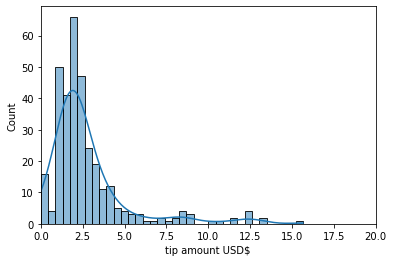

In [27]:
# take a random sample of taxi weather data for all months 
taxi_weather_df =  taxi_weather_data.sample(withReplacement=False, fraction=0.00001, seed=42).toPandas()

fig, ax = plt.subplots()
# plotting density for tip_amount
sns.histplot(data=taxi_weather_df['tip_amount'], ax = ax, kde=True)
ax.set_xlim(0,20)
ax.set_xlabel("tip amount USD$")
plt.savefig('../plots/tips_density.png')
plt.show()